In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, auc,
    accuracy_score, precision_score, recall_score, f1_score
)
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectKBest, f_classif

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

In [2]:
# 1. Loading the data
cancer_data = load_breast_cancer()
X = pd.DataFrame(cancer_data.data, columns=cancer_data.feature_names)
y = pd.Series(cancer_data.target)

print(f"Dataset Shape: {X.shape[0]} samples, {X.shape[1]} features")
print(f"Target Variable: {cancer_data.target_names[0]}")
print(f"Classes: {cancer_data.target_names}")

class_counts = y.value_counts()
print(f"\nClass Distribution:")
print(f"Benign (Non-cancerous): {class_counts[1]} samples ({class_counts[1]/len(y)*100:.1f}%)")
print(f"Malignant (Cancerous): {class_counts[0]} samples ({class_counts[0]/len(y)*100:.1f}%)")

Dataset Shape: 569 samples, 30 features
Target Variable: malignant
Classes: ['malignant' 'benign']

Class Distribution:
Benign (Non-cancerous): 357 samples (62.7%)
Malignant (Cancerous): 212 samples (37.3%)


In [3]:
# 2. Cleaning the data
# check missing values
missing_values = X.isnull().sum()
print(f"Missing values: {missing_values.sum()}")

# Check for duplicate rows
duplicate_rows = X.duplicated().sum()
print(f"Duplicate rows: {duplicate_rows}")

# Check for infinite values
infinite_values = np.isinf(X).sum().sum()
print(f"Infinite values: {infinite_values}")

print("✓ Data quality check complete - no issues found")

Missing values: 0
Duplicate rows: 0
Infinite values: 0
✓ Data quality check complete - no issues found


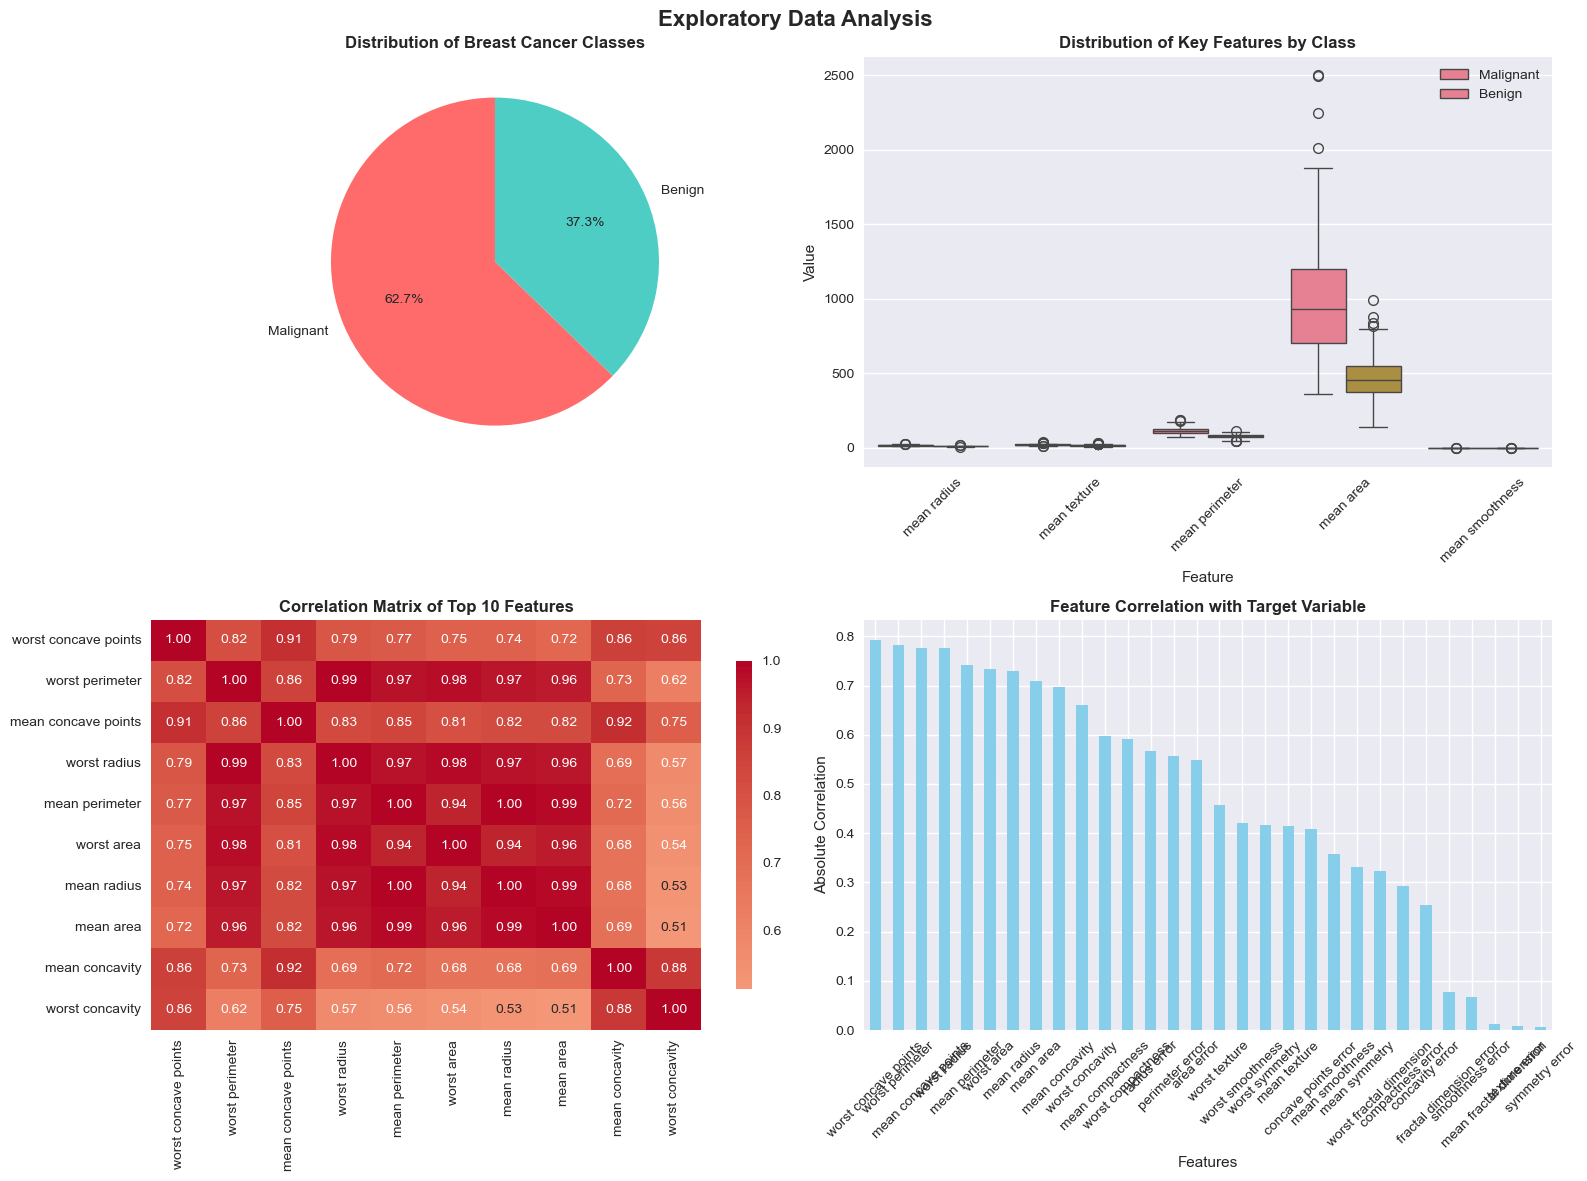


Statistical Summary by Class:
           Feature  Malignant_Mean  Benign_Mean  Difference
0      mean radius          17.463       12.147       5.316
1     mean texture          21.605       17.915       3.690
2   mean perimeter         115.365       78.075      37.290
3        mean area         978.376      462.790     515.586
4  mean smoothness           0.103        0.092       0.010


In [4]:
# 3. EDA
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Exploratory Data Analysis', fontsize=16, fontweight='bold')

# Class Distribution
axes[0, 0].pie(class_counts.values, labels=['Malignant', 'Benign'], autopct='%1.1f%%', 
               colors=['#ff6b6b', '#4ecdc4'], startangle=90)
axes[0, 0].set_title('Distribution of Breast Cancer Classes', fontweight='bold')

# Feature Statistics by Class
X_with_target = X.copy()
X_with_target['target'] = y
key_features = ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness']
feature_data = X_with_target[key_features + ['target']].melt(id_vars=['target'], 
                                                             var_name='Feature', 
                                                             value_name='Value')

sns.boxplot(data=feature_data, x='Feature', y='Value', hue='target', ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Key Features by Class', fontweight='bold')
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=45)
axes[0, 1].legend(['Malignant', 'Benign'])

# Correlation Heatmap
correlation_with_target = X.corrwith(y).abs().sort_values(ascending=False)
top_features = correlation_with_target.head(10).index
sns.heatmap(X[top_features].corr(), annot=True, cmap='coolwarm', center=0, 
            ax=axes[1, 0], fmt='.2f', cbar_kws={'shrink': 0.8})
axes[1, 0].set_title('Correlation Matrix of Top 10 Features', fontweight='bold')

# Feature Correlation
correlation_with_target.plot(kind='bar', ax=axes[1, 1], color='skyblue')
axes[1, 1].set_title('Feature Correlation with Target Variable', fontweight='bold')
axes[1, 1].set_xlabel('Features')
axes[1, 1].set_ylabel('Absolute Correlation')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Statistical summary by class
malignant_data = X[y == 0]
benign_data = X[y == 1]
comparison_df = pd.DataFrame({
    'Feature': key_features,
    'Malignant_Mean': [malignant_data[feature].mean() for feature in key_features],
    'Benign_Mean': [benign_data[feature].mean() for feature in key_features],
    'Difference': [malignant_data[feature].mean() - benign_data[feature].mean() 
                   for feature in key_features]
})
print(f"\nStatistical Summary by Class:")
print(comparison_df.round(3))


In [5]:
# 4. Feature Engineering
X_engineered = X.copy()

X_engineered['radius_perimeter_ratio'] = X['mean radius'] / X['mean perimeter']
X_engineered['area_perimeter_ratio'] = X['mean area'] / X['mean perimeter']
X_engineered['compactness'] = (X['mean perimeter'] ** 2) / (4 * np.pi * X['mean area'])
X_engineered['mean_std_ratio'] = X['mean radius'] / X['radius error']
X_engineered['worst_mean_ratio'] = X['worst radius'] / X['mean radius']
X_engineered['texture_smoothness_product'] = X['mean texture'] * X['mean smoothness']
X_engineered['concavity_compactness_sum'] = X['mean concavity'] + X['mean compactness']

print(f"Original features: {X.shape[1]}")
print(f"Engineered features: {X_engineered.shape[1]}")
print(f"Total features after engineering: {X_engineered.shape[1]}")

# Show correlation of new features with target
new_features = ['radius_perimeter_ratio', 'area_perimeter_ratio', 'compactness', 
                'mean_std_ratio', 'worst_mean_ratio', 'texture_smoothness_product', 
                'concavity_compactness_sum']

new_feature_corr = X_engineered[new_features].corrwith(y).abs().sort_values(ascending=False)
print(f"\nCorrelation of Engineered Features with Target:")
print(new_feature_corr.round(3))


Original features: 30
Engineered features: 37
Total features after engineering: 37

Correlation of Engineered Features with Target:
area_perimeter_ratio          0.716
concavity_compactness_sum     0.676
radius_perimeter_ratio        0.658
worst_mean_ratio              0.641
texture_smoothness_product    0.568
compactness                   0.506
mean_std_ratio                0.374
dtype: float64


In [6]:
# 5. Data Preprocessing

X_train, X_test, y_train, y_test = train_test_split(
    X_engineered, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Features scaled using StandardScaler")

# Feature selection
k_best = 20
selector = SelectKBest(score_func=f_classif, k=k_best)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

selected_feature_names = X_engineered.columns[selector.get_support()].tolist()
print(f"Selected top {k_best} features for modeling")

Training set: 455 samples
Testing set: 114 samples
Features scaled using StandardScaler
Selected top 20 features for modeling


In [7]:
# 6. Model Training of the 7 models below

models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Support Vector Machine': SVC(random_state=42, probability=True),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Neural Network': MLPClassifier(random_state=42, max_iter=1000, hidden_layer_sizes=(100, 50))
}

# Train and evaluate all these 7 models
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    model.fit(X_train_selected, y_train)
    
    y_pred = model.predict(X_test_selected)
    y_prob = model.predict_proba(X_test_selected)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

   # Cross-validation score
    cv_scores = cross_val_score(model, X_train_selected, y_train, cv=5, scoring='accuracy')
    
    # Store results
    results[name] = {
        'model': model,
        'y_pred': y_pred,
        'y_prob': y_prob,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std()
    }
    
    print(f"  F1-Score: {f1:.4f}")
    print(f"  Accuracy: {accuracy:.4f}")


Training Logistic Regression...
  F1-Score: 0.9861
  Accuracy: 0.9825

Training Decision Tree...
  F1-Score: 0.9220
  Accuracy: 0.9035

Training Random Forest...
  F1-Score: 0.9655
  Accuracy: 0.9561

Training Gradient Boosting...
  F1-Score: 0.9583
  Accuracy: 0.9474

Training Support Vector Machine...
  F1-Score: 0.9660
  Accuracy: 0.9561

Training K-Nearest Neighbors...
  F1-Score: 0.9863
  Accuracy: 0.9825

Training Neural Network...
  F1-Score: 0.9714
  Accuracy: 0.9649


In [8]:
# 7. Compare the 7 Models and select top 3 models

performance_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[name]['accuracy'] for name in results.keys()],
    'Precision': [results[name]['precision'] for name in results.keys()],
    'Recall': [results[name]['recall'] for name in results.keys()],
    'F1-Score': [results[name]['f1'] for name in results.keys()],
    'CV Accuracy': [results[name]['cv_mean'] for name in results.keys()],
    'CV Std': [results[name]['cv_std'] for name in results.keys()]
})

performance_df = performance_df.sort_values('F1-Score', ascending=False)
print("MODEL PERFORMANCE COMPARISON:")
print(performance_df.round(4))

# Select top 3 models
top_3_models = performance_df.head(3)['Model'].tolist()
print(f"\nTOP 3 MODELS SELECTED:")
print(f"1. {top_3_models[0]} (F1-Score: {performance_df.iloc[0]['F1-Score']:.4f})")
print(f"2. {top_3_models[1]} (F1-Score: {performance_df.iloc[1]['F1-Score']:.4f})")
print(f"3. {top_3_models[2]} (F1-Score: {performance_df.iloc[2]['F1-Score']:.4f})")

MODEL PERFORMANCE COMPARISON:
                    Model  Accuracy  Precision  Recall  F1-Score  CV Accuracy  \
5     K-Nearest Neighbors    0.9825     0.9730  1.0000    0.9863       0.9582   
0     Logistic Regression    0.9825     0.9861  0.9861    0.9861       0.9714   
6          Neural Network    0.9649     1.0000  0.9444    0.9714       0.9714   
4  Support Vector Machine    0.9561     0.9467  0.9861    0.9660       0.9648   
2           Random Forest    0.9561     0.9589  0.9722    0.9655       0.9582   
3       Gradient Boosting    0.9474     0.9583  0.9583    0.9583       0.9692   
1           Decision Tree    0.9035     0.9420  0.9028    0.9220       0.9407   

   CV Std  
5  0.0176  
0  0.0132  
6  0.0132  
4  0.0108  
2  0.0162  
3  0.0128  
1  0.0204  

TOP 3 MODELS SELECTED:
1. K-Nearest Neighbors (F1-Score: 0.9863)
2. Logistic Regression (F1-Score: 0.9861)
3. Neural Network (F1-Score: 0.9714)


In [9]:
# 8. Hyperparameter Tuning

param_grids = {
    'Logistic Regression': {
        'C': [0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }
}

tuned_models = {}

for model_name in top_3_models:
    if model_name in param_grids:
        print(f"\nTuning {model_name}...")
        
        base_model = models[model_name]
        param_grid = param_grids[model_name]
        
        grid_search = GridSearchCV(
            base_model, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=0
        )
        grid_search.fit(X_train_selected, y_train)
        
        tuned_models[model_name] = {
            'model': grid_search.best_estimator_,
            'best_params': grid_search.best_params_,
            'best_score': grid_search.best_score_
        }
        
        print(f"  Best parameters: {grid_search.best_params_}")
        print(f"  Best CV F1-score: {grid_search.best_score_:.4f}")
        
        # Evaluate on test set
        y_pred_tuned = grid_search.predict(X_test_selected)
        test_f1 = f1_score(y_test, y_pred_tuned)
        print(f"  Test F1-score: {test_f1:.4f}")


Tuning Logistic Regression...
  Best parameters: {'C': 1, 'penalty': 'l2', 'solver': 'saga'}
  Best CV F1-score: 0.9773
  Test F1-score: 0.9861


In [12]:
# 9. Comparing original vs tuned models
final_comparison = []

for model_name in top_3_models:
    if model_name in tuned_models:
        original_f1 = results[model_name]['f1']
        
        tuned_model = tuned_models[model_name]['model']
        y_pred_tuned = tuned_model.predict(X_test_selected)
        tuned_f1 = f1_score(y_test, y_pred_tuned)
        
        final_comparison.append({
            'Model': model_name,
            'Original F1': original_f1,
            'Tuned F1': tuned_f1,
            'Improvement': tuned_f1 - original_f1
        })

if final_comparison:
    final_df = pd.DataFrame(final_comparison)
    final_df = final_df.sort_values('Tuned F1', ascending=False)
    print("FINAL MODEL COMPARISON (After Hyperparameter Tuning):")
    print(final_df.round(4))
    
    # Determine best overall model
    best_overall_model = final_df.iloc[0]['Model']
    best_overall_f1 = final_df.iloc[0]['Tuned F1']
    
    print(f" BEST OVERALL MODEL: {best_overall_model}")
    print(f"F1-Score: {best_overall_f1:.4f}")
    print(f"Best Parameters: {tuned_models[best_overall_model]['best_params']}")

FINAL MODEL COMPARISON (After Hyperparameter Tuning):
                 Model  Original F1  Tuned F1  Improvement
0  Logistic Regression       0.9861    0.9861          0.0
 BEST OVERALL MODEL: Logistic Regression
F1-Score: 0.9861
Best Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'saga'}


In [13]:
# 10. Feature importance of the best model - Logistic Regression
best_model = tuned_models[best_overall_model]['model']

if hasattr(best_model, 'coef_'): 
    importance_df = pd.DataFrame({
        'feature': selected_feature_names,
        'importance': abs(best_model.coef_[0])
    }).sort_values('importance', ascending=False)
    
elif hasattr(best_model, 'feature_importances_'):  
    importance_df = pd.DataFrame({
        'feature': selected_feature_names,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)

print(f"Top 10 Most Important Features for {best_overall_model}:")
print(importance_df.head(10)[['feature', 'importance']].round(4))

Top 10 Most Important Features for Logistic Regression:
                       feature  importance
18  texture_smoothness_product      1.7023
17            worst_mean_ratio      1.4253
14        worst concave points      1.4114
5          mean concave points      0.9018
3             mean compactness      0.8551
13             worst concavity      0.7292
11                  worst area      0.7211
9                 worst radius      0.6858
16        area_perimeter_ratio      0.6826
8                   area error      0.6014


In [17]:
# 11. Conclusion
best_model = tuned_models[best_overall_model]['model']
y_pred_final = best_model.predict(X_test_selected)
y_prob_final = best_model.predict_proba(X_test_selected)[:, 1]

# Confusion matrix
cm_final = confusion_matrix(y_test, y_pred_final)
tn, fp, fn, tp = cm_final.ravel()

print(F" FINAL PERFORMANCE METRICS:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_final):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_final):.4f}")
print(f"Recall (Sensitivity): {recall_score(y_test, y_pred_final):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_final):.4f}")

print(F" BUSINESS METRICS:")
print(f"True Positives (Correctly identified cancer): {tp}")
print(f"False Positives (False alarm): {fp}")
print(f"False Negatives (Missed cancer): {fn}")
print(f"True Negatives (Correctly identified benign): {tn}")

# Calculate medical metrics
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
ppv = tp / (tp + fp)
npv = tn / (tn + fn)

print(f" MEDICAL METRICS:")
print(f"Sensitivity (True Positive Rate): {sensitivity:.4f}")
print(f"Specificity (True Negative Rate): {specificity:.4f}")
print(f"Positive Predictive Value: {ppv:.4f}")
print(f"Negative Predictive Value: {npv:.4f}")

print(f" CONCLUSION:")
print(f"The {best_overall_model} model is the best performer for breast cancer prediction.")
print(f"It achieves an F1-Score of {f1_score(y_test, y_pred_final):.4f} after hyperparameter tuning.")
print(f"This model provides the optimal balance between precision and recall for this medical diagnosis.")

 FINAL PERFORMANCE METRICS:
Accuracy: 0.9825
Precision: 0.9861
Recall (Sensitivity): 0.9861
F1-Score: 0.9861
 BUSINESS METRICS:
True Positives (Correctly identified cancer): 71
False Positives (False alarm): 1
False Negatives (Missed cancer): 1
True Negatives (Correctly identified benign): 41
 MEDICAL METRICS:
Sensitivity (True Positive Rate): 0.9861
Specificity (True Negative Rate): 0.9762
Positive Predictive Value: 0.9861
Negative Predictive Value: 0.9762
 CONCLUSION:
The Logistic Regression model is the best performer for breast cancer prediction.
It achieves an F1-Score of 0.9861 after hyperparameter tuning.
This model provides the optimal balance between precision and recall for this medical diagnosis.
